<a href="https://colab.research.google.com/github/abhishek9686/Tensorflow/blob/master/Transfer_Learning_and_Fine_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow-gpu==2.0.0

     |████████████████████████████████| 380.8MB 44kB/s 
     |████████████████████████████████| 450kB 44.4MB/s 
     |████████████████████████████████| 3.8MB 44.7MB/s 
     |████████████████████████████████| 81kB 10.1MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.0.2 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.0.1 which is incompatible.
ERROR: tensorboard 2.0.2 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.7.1 which is incompatible.
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled goog

In [0]:
import tensorflow as tf

In [3]:
print(tf.__version__)

2.0.0


In [4]:
!pip install tqdm

In [5]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O ./cats_and_dogs_filtered.zip

--2019-11-26 05:32:19--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.133.128, 2a00:1450:400c:c00::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.133.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘./cats_and_dogs_filtered.zip’

./cats_and_dogs_fil 100%[===================>]  65.43M   242MB/s    in 0.3s    

2019-11-26 05:32:19 (242 MB/s) - ‘./cats_and_dogs_filtered.zip’ saved [68606236/68606236]



#Data Preprocessing

In [0]:
import os
import zipfile
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from tensorflow.keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

In [0]:
dataset_path="./cats_and_dogs_filtered.zip"

In [0]:
zipobj=zipfile.ZipFile(file=dataset_path,mode="r")

In [0]:
zipobj.extractall("./")

In [0]:
zipobj.close()

In [0]:
dataset_path_new="./cats_and_dogs_filtered/"

In [0]:
train_dir=os.path.join(dataset_path_new,"train")
validation_dir=os.path.join(dataset_path_new,"validation")

In [13]:
print(train_dir)

./cats_and_dogs_filtered/train


# Loading Pre-trained model(MobileNetV2)


In [0]:
img_shape=(128,128,3)

In [15]:
base_model=tf.keras.applications.MobileNetV2(input_shape=img_shape,include_top=False,weights="imagenet")

9412608/9406464 [==============================] - 1s 0us/step


In [16]:
base_model.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 129, 129, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

# Freezing Base Model

In [0]:
base_model.trainable=False

#Adding custom head for our Network

In [18]:
base_model.output

<tf.Tensor 'out_relu/Identity:0' shape=(None, 4, 4, 1280) dtype=float32>

In [0]:
#global avg maxpooling layer takes whole input instead of parts of input and takes avg of all numbers

In [0]:
global_average_layer=tf.keras.layers.GlobalAveragePooling2D()(base_model.output)

In [21]:
global_average_layer

<tf.Tensor 'global_average_pooling2d/Identity:0' shape=(None, 1280) dtype=float32>

In [0]:
prediction_layer=tf.keras.layers.Dense(units=1,activation='sigmoid')(global_average_layer)

# Defining the Model

In [0]:
model=tf.keras.models.Model(inputs=base_model.input,outputs=prediction_layer)

In [24]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 129, 129, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
______________________________________________________________________________________________

#Compiling the Model

In [0]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),loss="binary_crossentropy",metrics=["accuracy"])

# Creating Data Generators

In [0]:
data_gen_train=ImageDataGenerator(rescale=1/255.)
data_gen_valid=ImageDataGenerator(rescale=1/255.)


In [27]:
train_generator=data_gen_train.flow_from_directory(train_dir,target_size=(128,128),batch_size=128,class_mode="binary")

Found 2000 images belonging to 2 classes.


In [28]:
valid_generator=data_gen_valid.flow_from_directory(validation_dir,target_size=(128,128),batch_size=128,class_mode="binary")

Found 1000 images belonging to 2 classes.


# Training

In [30]:
model.fit_generator(train_generator,epochs=10,validation_data=valid_generator)

Epoch 1/10
16/16 [==============================] - 16s 1s/step - loss: 0.6101 - accuracy: 0.6705 - val_loss: 0.4786 - val_accuracy: 0.7750
Epoch 2/10
16/16 [==============================] - 12s 776ms/step - loss: 0.5602 - accuracy: 0.7140 - val_loss: 0.4364 - val_accuracy: 0.8070
Epoch 3/10
16/16 [==============================] - 12s 769ms/step - loss: 0.5213 - accuracy: 0.7515 - val_loss: 0.4055 - val_accuracy: 0.8200
Epoch 4/10
16/16 [==============================] - 12s 778ms/step - loss: 0.4836 - accuracy: 0.7810 - val_loss: 0.3768 - val_accuracy: 0.8310
Epoch 5/10
16/16 [==============================] - 12s 773ms/step - loss: 0.4510 - accuracy: 0.7970 - val_loss: 0.3485 - val_accuracy: 0.8470
Epoch 6/10
16/16 [==============================] - 12s 761ms/step - loss: 0.4184 - accuracy: 0.8275 - val_loss: 0.3267 - val_accuracy: 0.8620
Epoch 7/10
16/16 [==============================] - 12s 768ms/step - loss: 0.3924 - accuracy: 0.8380 - val_loss: 0.3049 - val_accuracy: 0.8740
Ep

# evaluating model

In [0]:
valid_loss,valid_accuracy=model.evaluate_generator(valid_generator)

In [32]:
print("accuracy after transfer Learning:{}".format(valid_accuracy))

accuracy after transfer Learning:0.890999972820282


In [33]:
len(train_generator)

16

In [0]:
print(train_generator)

In [0]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      #plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

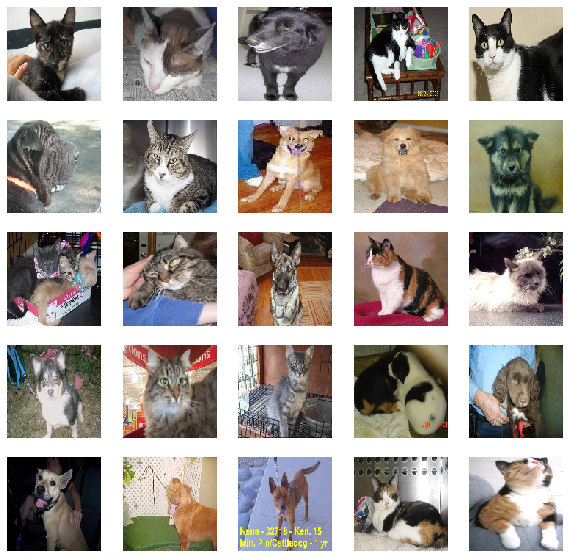

In [35]:
image_batch, label_batch = next(train_generator)
show_batch(image_batch, label_batch)

In [0]:
i,j=train_generator[0]

In [37]:
i[0].shape

(128, 128, 3)

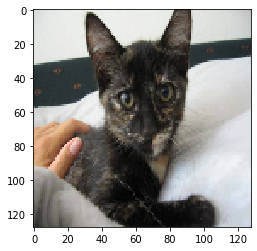

In [38]:
plt.imshow(i[0])

In [0]:
from tensorflow.keras.preprocessing.image import load_img,img_to_array,array_to_img 

In [0]:
img=load_img('/content/20191125_105834.jpg',target_size=(128,128))

In [0]:
plt.imshow(img)

In [0]:
print(type(i[0]))

In [0]:
img_array=img_to_array(img)

In [0]:
img_array.shape

In [0]:
fimg=np.reshape(img_array,(1,128,128,3))

# Fine Tuning

# Un-freeze few top layers from the model

In [0]:
base_model.trainable=True

In [40]:
print("number of layers in the base model: {}".format(len(base_model.layers)))

number of layers in the base model: 155


In [0]:
fine_tune_at=100

In [0]:
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable=False

# Compiling the model for fine-tuning

In [0]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001),loss='binary_crossentropy',metrics=['accuracy'])

# Training the fine tuned model

In [44]:
model.fit_generator(train_generator,epochs=5,validation_data=valid_generator)

Epoch 1/5
16/16 [==============================] - 14s 897ms/step - loss: 0.1512 - accuracy: 0.9425 - val_loss: 0.0923 - val_accuracy: 0.9730
Epoch 2/5
16/16 [==============================] - 13s 822ms/step - loss: 0.0210 - accuracy: 0.9980 - val_loss: 0.0940 - val_accuracy: 0.9710
Epoch 3/5
16/16 [==============================] - 13s 819ms/step - loss: 0.0089 - accuracy: 0.9995 - val_loss: 0.0944 - val_accuracy: 0.9730
Epoch 4/5
16/16 [==============================] - 13s 820ms/step - loss: 0.0045 - accuracy: 1.0000 - val_loss: 0.0921 - val_accuracy: 0.9730
Epoch 5/5
16/16 [==============================] - 13s 826ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.1251 - val_accuracy: 0.9650


# Evaluating the fine tuned model

In [0]:
valid_loss,valid_accuracy=model.evaluate_generator(valid_generator)

In [46]:
print("validation accuracy after fine tuning:{}".format(valid_accuracy))

validation accuracy after fine tuning:0.9649999737739563
